<a href="https://colab.research.google.com/github/rayen03/Brain-Tumor-segmentation/blob/main/Tumor_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Environment Setup**

This section must be executed at all times

In [1]:
#Libraries
import os
import zipfile
import copy
import json
import random
import warnings
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from PIL import Image, ImageEnhance
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.models import resnet18, efficientnet_b0

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, f1_score, accuracy_score
from sklearn.linear_model import LogisticRegression

warnings.filterwarnings('ignore')


In [3]:
# kaggle setup
!pip install -q kaggle
!mkdir -p ~/.kaggle

# Upload API key
from google.colab import files
print("upload kaggle.json file:")
uploaded = files.upload()

!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download BRISC2025 dataset
print("Downloading BRISC2025 dataset...")
!kaggle datasets download -d briscdataset/brisc2025

# Set up paths
zip_path = "/content/brisc2025.zip"
dataset_path = "/content/brisc2025"

# Extract dataset
if not os.path.exists(dataset_path):
    print(f"Extracting {zip_path}...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall("/content")
    print("Extraction complete")
else:
    print("Dataset already extracted")

# Define paths for classification task
CLASSIFICATION_PATH = "/content/brisc2025/classification_task"
TRAIN_PATH = f"{CLASSIFICATION_PATH}/train"
TEST_PATH = f"{CLASSIFICATION_PATH}/test"

# Define the tumor classes
CLASSES = ['glioma', 'meningioma', 'pituitary', 'no_tumor']



upload kaggle.json file:


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/briscdataset/brisc2025
License(s): Attribution 4.0 International (CC BY 4.0)
 89% 220M/248M [00:00<00:00, 590MB/s] 
100% 248M/248M [00:00<00:00, 593MB/s]
Extracting /content/brisc2025.zip...
Extraction complete


# **Data analysis**

BRISC2025 Classification Dataset Structure:

TRAIN SET:
------------------------------
glioma      : 1147 images
meningioma  : 1329 images
pituitary   : 1457 images
no_tumor    : 1067 images
Total       : 5000 images

TEST SET:
------------------------------
glioma      :  254 images
meningioma  :  306 images
pituitary   :  300 images
no_tumor    :  140 images
Total       : 1000 images

Dataset Summary:
Training images: 5000
Test images: 1000
Total images: 6000

Loading sample images...

glioma sample:
  File: brisc2025_train_00362_gl_ax_t1.jpg
  Size: (512, 512)
  Mode: L

meningioma sample:
  File: brisc2025_train_02013_me_sa_t1.jpg
  Size: (217, 232)
  Mode: RGB

pituitary sample:
  File: brisc2025_train_04985_pi_sa_t1.jpg
  Size: (512, 512)
  Mode: L

no_tumor sample:
  File: brisc2025_train_02686_no_ax_t1.jpg
  Size: (512, 512)
  Mode: RGB


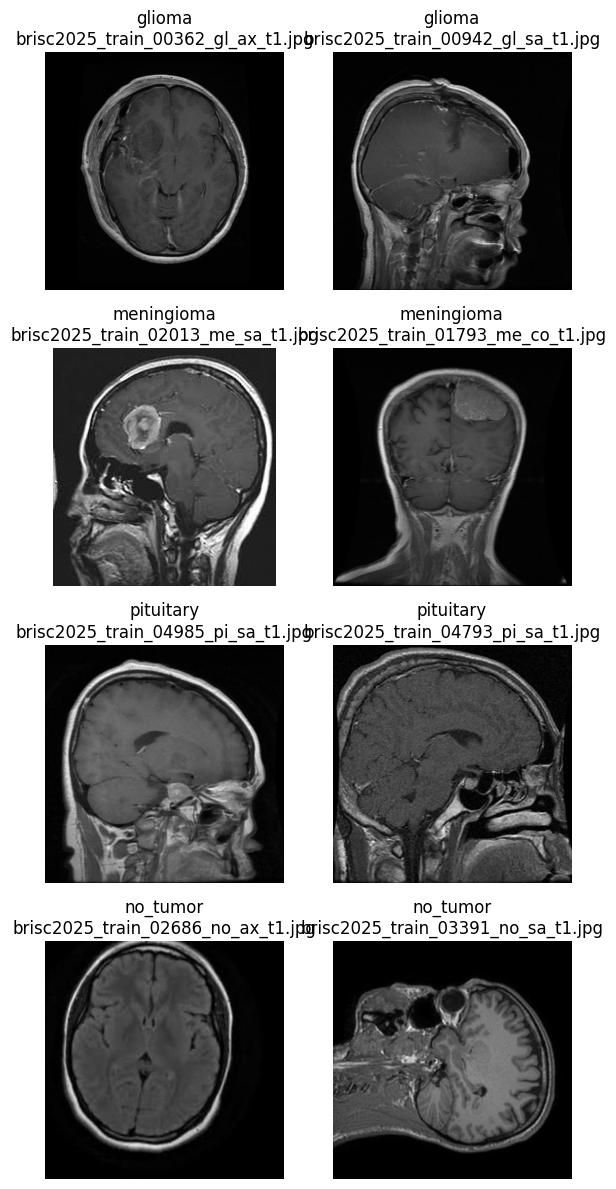


Detailed Dataset Analysis:

TRAIN - glioma:
  Images: 1147
  Planes: {'ax': 394, 'sa': 323, 'co': 430}
  Tumor types: {'gl': 1147}

TRAIN - meningioma:
  Images: 1329
  Planes: {'sa': 480, 'co': 426, 'ax': 423}
  Tumor types: {'me': 1329}

TRAIN - pituitary:
  Images: 1457
  Planes: {'sa': 521, 'co': 510, 'ax': 426}
  Tumor types: {'pi': 1457}

TRAIN - no_tumor:
  Images: 1067
  Planes: {'ax': 352, 'sa': 405, 'co': 310}
  Tumor types: {'no': 1067}

TEST - glioma:
  Images: 254
  Planes: {'ax': 85, 'sa': 88, 'co': 81}
  Tumor types: {'gl': 254}

TEST - meningioma:
  Images: 306
  Planes: {'co': 86, 'ax': 137, 'sa': 83}
  Tumor types: {'me': 306}

TEST - pituitary:
  Images: 300
  Planes: {'co': 90, 'ax': 124, 'sa': 86}
  Tumor types: {'pi': 300}

TEST - no_tumor:
  Images: 140
  Planes: {'co': 48, 'ax': 52, 'sa': 40}
  Tumor types: {'no': 140}

Example: Loading a specific image...
Loaded: brisc2025_train_00362_gl_ax_t1.jpg
PIL Image size: (512, 512)
PIL Image mode: L
NumPy array shape:

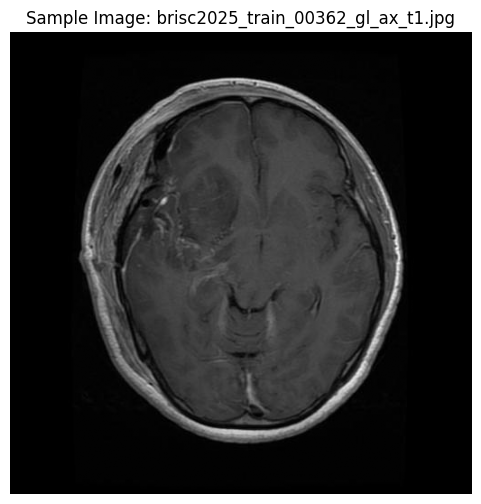


Example: Getting all glioma images from training set...
Found 1147 glioma images

BRISC2025 Classification Dataset Ready!
Available classes: ['glioma', 'meningioma', 'pituitary', 'no_tumor']
Use the helper functions above to load and work with the data.


In [4]:
print("BRISC2025 Classification Dataset Structure:")
print("="*50)

# Analyze dataset statistics
def analyze_dataset(split_path, split_name):
    """Analyze and display dataset statistics"""
    print(f"\n{split_name.upper()} SET:")
    print("-" * 30)

    total_images = 0
    class_counts = {}

    for class_name in CLASSES:
        class_path = Path(split_path) / class_name
        if class_path.exists():
            image_files = list(class_path.glob("*.jpg"))
            class_counts[class_name] = len(image_files)
            total_images += len(image_files)
            print(f"{class_name:12}: {len(image_files):4} images")

    print(f"{'Total':12}: {total_images:4} images")
    return class_counts, total_images

# Analyze train and test sets
train_counts, train_total = analyze_dataset(TRAIN_PATH, "train")
test_counts, test_total = analyze_dataset(TEST_PATH, "test")

print(f"\nDataset Summary:")
print(f"Training images: {train_total}")
print(f"Test images: {test_total}")
print(f"Total images: {train_total + test_total}")

# Function to load and display sample images
def load_sample_images(num_samples_per_class=2):
    """Load and display sample images from each class"""
    fig, axes = plt.subplots(len(CLASSES), num_samples_per_class,
                            figsize=(num_samples_per_class * 3, len(CLASSES) * 3))

    if len(CLASSES) == 1:
        axes = axes.reshape(1, -1)
    if num_samples_per_class == 1:
        axes = axes.reshape(-1, 1)

    for i, class_name in enumerate(CLASSES):
        class_path = Path(TRAIN_PATH) / class_name
        image_files = list(class_path.glob("*.jpg"))

        for j in range(min(num_samples_per_class, len(image_files))):
            if len(image_files) > j:
                # Load image
                img_path = image_files[j]
                image = Image.open(img_path)

                # Display image
                axes[i, j].imshow(image, cmap='gray')
                axes[i, j].set_title(f"{class_name}\n{img_path.name}")
                axes[i, j].axis('off')

                # Print image info
                if j == 0:  # Print info for first image of each class
                    print(f"\n{class_name} sample:")
                    print(f"  File: {img_path.name}")
                    print(f"  Size: {image.size}")
                    print(f"  Mode: {image.mode}")

    plt.tight_layout()
    plt.show()

# Load and display sample images
print("\nLoading sample images...")
load_sample_images(num_samples_per_class=2)

# Function to load a specific image
def load_brisc_image(image_path):
    """
    Load a single BRISC2025 image

    Args:
        image_path: Path to the image file

    Returns:
        PIL Image object and numpy array
    """
    image_path = Path(image_path)

    if not image_path.exists():
        raise FileNotFoundError(f"Image not found: {image_path}")

    # Load image
    pil_image = Image.open(image_path)
    np_image = np.array(pil_image)

    return pil_image, np_image

# Function to parse filename information
def parse_filename(filename):
    """
    Parse BRISC2025 filename to extract information

    Format: brisc2025_{split}_{id}_{tumor_type}_{plane}_{modality}.jpg
    Example: brisc2025_train_00362_gl_ax_t1.jpg
    """
    parts = filename.replace('.jpg', '').split('_')

    if len(parts) >= 6:
        return {
            'dataset': parts[0],
            'split': parts[1],
            'id': parts[2],
            'tumor_type': parts[3],
            'plane': parts[4],  # ax (axial), sa (sagittal), co (coronal)
            'modality': parts[5]  # t1
        }
    return {}

# Function to create a dataset summary
def create_dataset_summary():
    """Create a comprehensive dataset summary"""
    summary_data = []

    for split in ['train', 'test']:
        split_path = TRAIN_PATH if split == 'train' else TEST_PATH

        for class_name in CLASSES:
            class_path = Path(split_path) / class_name
            if class_path.exists():
                image_files = list(class_path.glob("*.jpg"))

                # Analyze planes and other metadata
                planes = {}
                tumor_types = {}

                for img_file in image_files:
                    info = parse_filename(img_file.name)
                    if info:
                        plane = info.get('plane', 'unknown')
                        tumor_type = info.get('tumor_type', 'unknown')

                        planes[plane] = planes.get(plane, 0) + 1
                        tumor_types[tumor_type] = tumor_types.get(tumor_type, 0) + 1

                summary_data.append({
                    'split': split,
                    'class': class_name,
                    'count': len(image_files),
                    'planes': dict(planes),
                    'tumor_types': dict(tumor_types)
                })

    return summary_data

# Create and display dataset summary
print("\nDetailed Dataset Analysis:")
print("="*50)
summary = create_dataset_summary()

for item in summary:
    print(f"\n{item['split'].upper()} - {item['class']}:")
    print(f"  Images: {item['count']}")
    print(f"  Planes: {item['planes']}")
    print(f"  Tumor types: {item['tumor_types']}")

# Example: Load and analyze a specific image
print("\nExample: Loading a specific image...")
try:
    # Get first glioma image from training set
    glioma_path = Path(TRAIN_PATH) / 'glioma'
    glioma_files = list(glioma_path.glob("*.jpg"))

    if glioma_files:
        sample_image_path = glioma_files[0]
        pil_img, np_img = load_brisc_image(sample_image_path)

        print(f"Loaded: {sample_image_path.name}")
        print(f"PIL Image size: {pil_img.size}")
        print(f"PIL Image mode: {pil_img.mode}")
        print(f"NumPy array shape: {np_img.shape}")
        print(f"NumPy array dtype: {np_img.dtype}")
        print(f"Value range: {np_img.min()} - {np_img.max()}")

        # Parse filename
        file_info = parse_filename(sample_image_path.name)
        print(f"File info: {file_info}")

        # Display the image
        plt.figure(figsize=(6, 6))
        plt.imshow(np_img, cmap='gray')
        plt.title(f"Sample Image: {sample_image_path.name}")
        plt.axis('off')
        plt.show()

except Exception as e:
    print(f"Error loading sample image: {e}")

# Helper function to get all images for a specific class
def get_class_images(class_name, split='train'):
    """Get all image paths for a specific class"""
    split_path = TRAIN_PATH if split == 'train' else TEST_PATH
    class_path = Path(split_path) / class_name

    if not class_path.exists():
        print(f"Class path does not exist: {class_path}")
        return []

    return list(class_path.glob("*.jpg"))

# Example usage
print(f"\nExample: Getting all glioma images from training set...")
glioma_images = get_class_images('glioma', 'train')
print(f"Found {len(glioma_images)} glioma images")

print("\n" + "="*50)
print("BRISC2025 Classification Dataset Ready!")
print("Available classes:", CLASSES)
print("Use the helper functions above to load and work with the data.")
print("="*50)

# **Data Preprocessing**

Initializing preprocessor and augmenter...
Processing train split...

Processing class: glioma


Processing glioma: 100%|██████████| 1147/1147 [00:19<00:00, 57.94it/s]



Processing class: meningioma


Processing meningioma: 100%|██████████| 1329/1329 [00:18<00:00, 71.06it/s]



Processing class: pituitary


Processing pituitary: 100%|██████████| 1457/1457 [00:22<00:00, 65.75it/s]



Processing class: no_tumor


Processing no_tumor: 100%|██████████| 1067/1067 [00:15<00:00, 69.34it/s]



train processing complete:
  Original images processed: 5000
  Augmented images created: 10000
  Total images in train: 15000
Processing test split...

Processing class: glioma


Processing glioma: 100%|██████████| 254/254 [00:02<00:00, 120.84it/s]



Processing class: meningioma


Processing meningioma: 100%|██████████| 306/306 [00:02<00:00, 142.30it/s]



Processing class: pituitary


Processing pituitary: 100%|██████████| 300/300 [00:03<00:00, 88.32it/s]



Processing class: no_tumor


Processing no_tumor: 100%|██████████| 140/140 [00:00<00:00, 196.51it/s]



test processing complete:
  Original images processed: 1000

Preprocessing complete!
Preprocessed data saved to: /content/brisc2025_preprocessed

Visualizing preprocessing results...


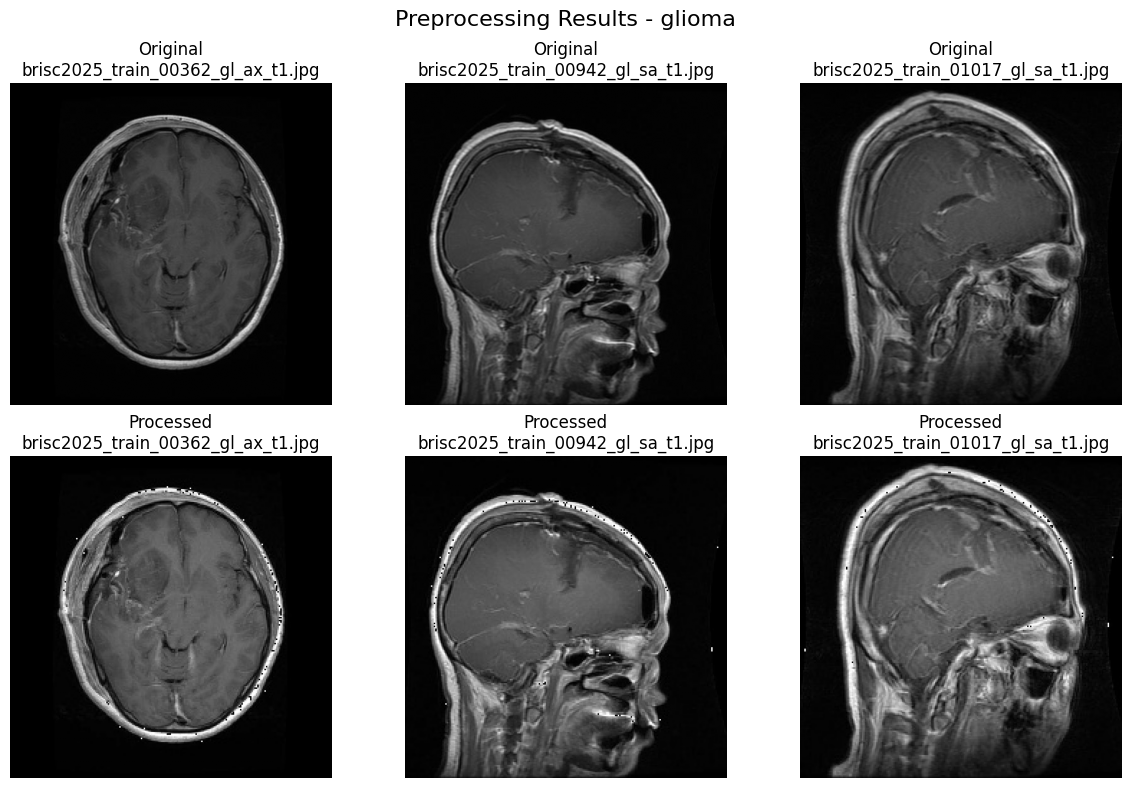

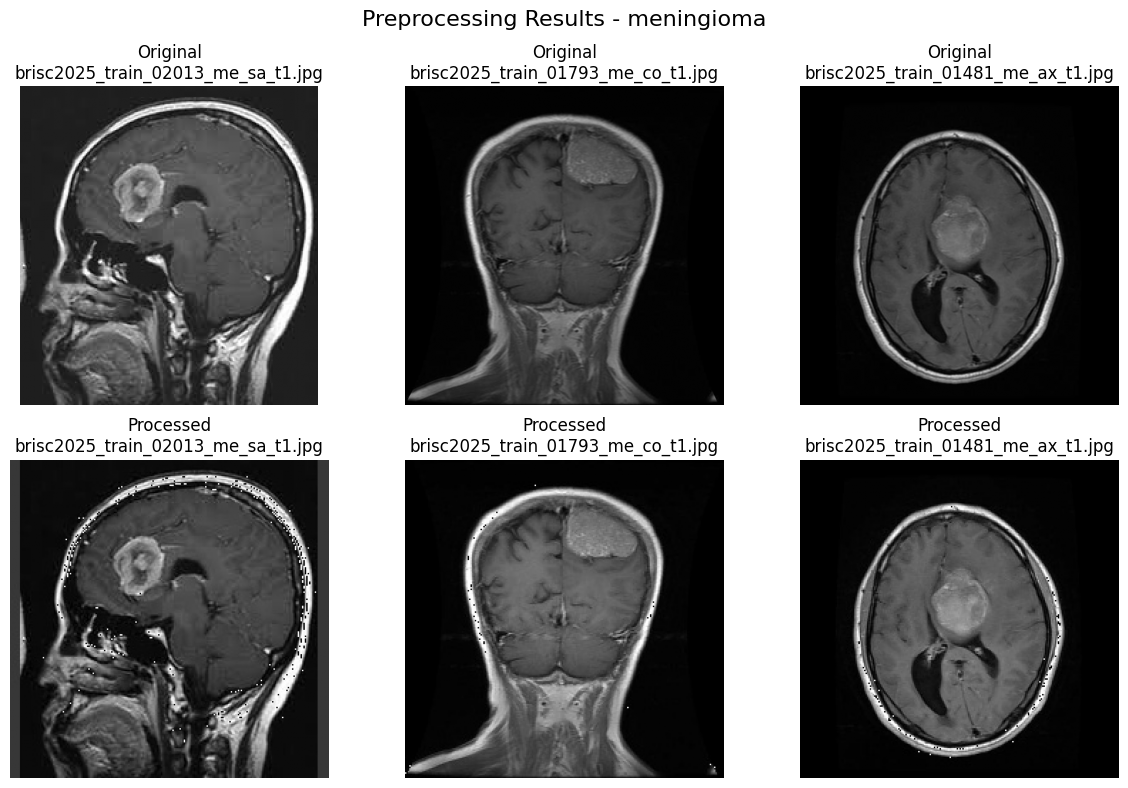


Visualizing augmentation examples...


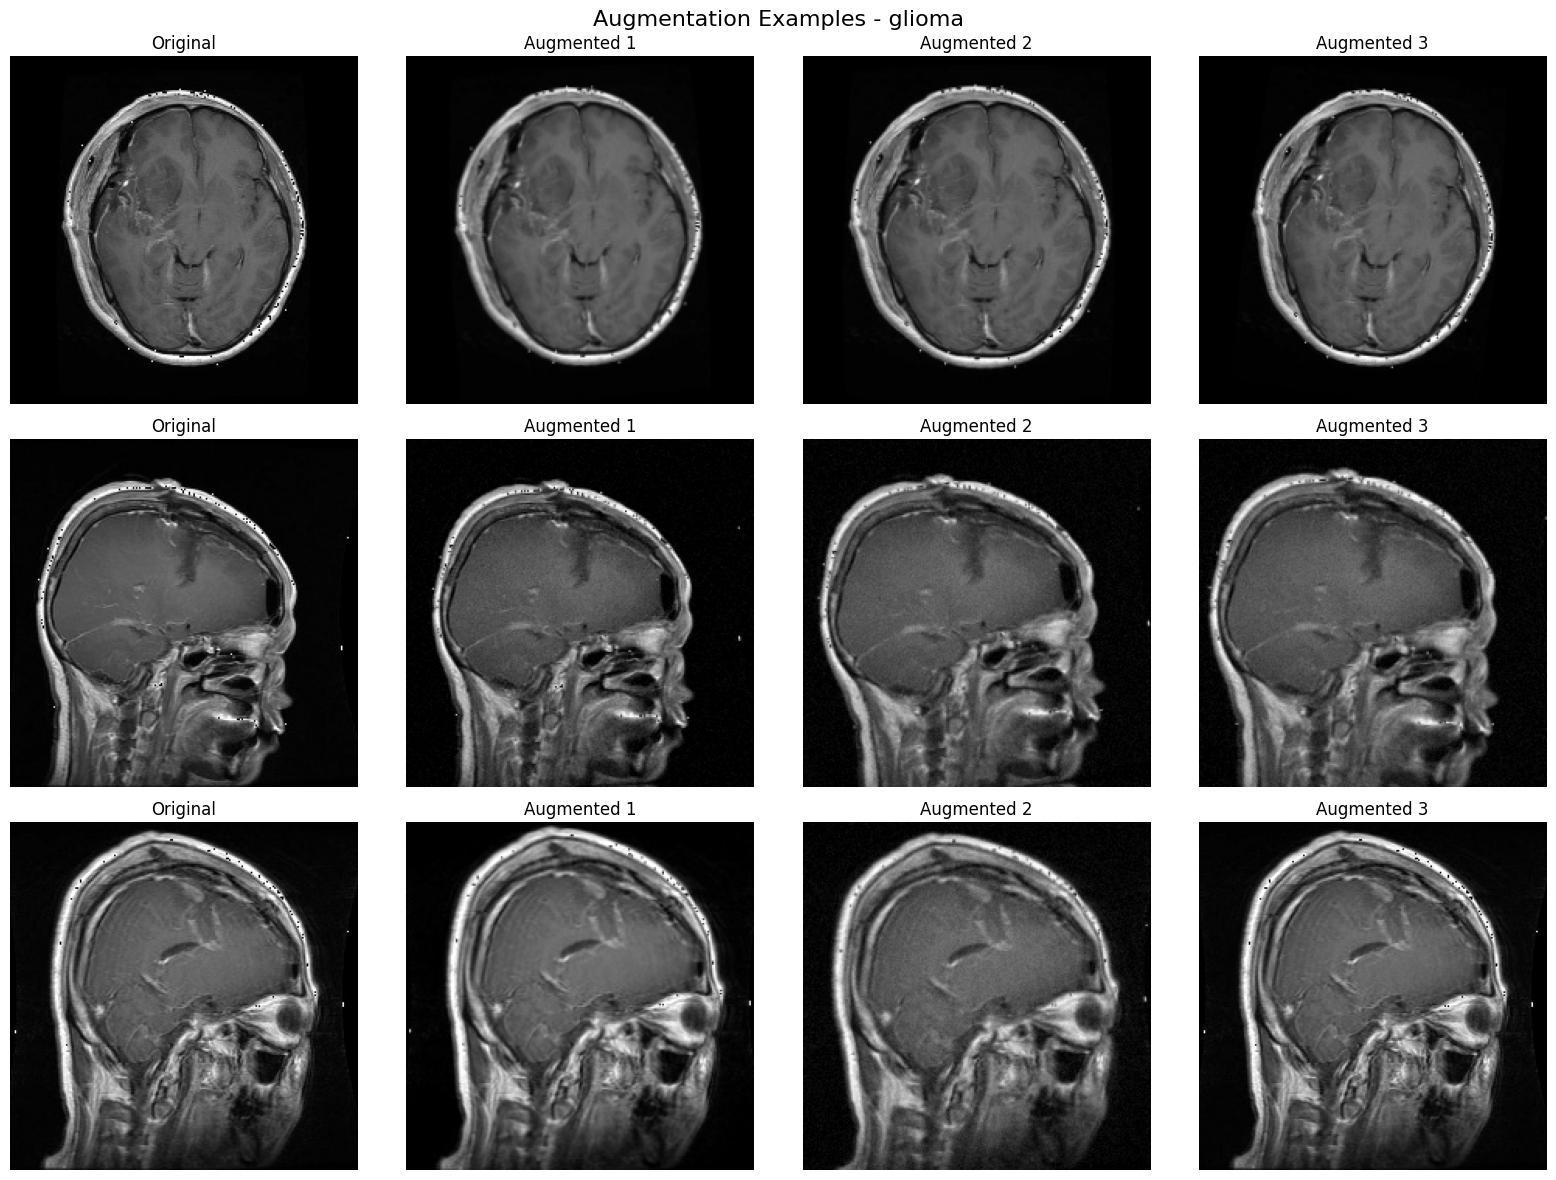


Final Dataset Statistics:

TRAIN SET:
  glioma      :  3441 images
  meningioma  :  3987 images
  pituitary   :  4371 images
  no_tumor    :  3201 images
  Total       : 15000 images

TEST SET:
  glioma      :   254 images
  meningioma  :   306 images
  pituitary   :   300 images
  no_tumor    :   140 images
  Total       :  1000 images

Dataset preprocessing completed successfully!
Your data is ready for training!


In [5]:
# Set random seeds for reproducibility
np.random.seed(42)
random.seed(42)

# Create preprocessed data directory
PREPROCESSED_PATH = "/content/brisc2025_preprocessed"
os.makedirs(f"{PREPROCESSED_PATH}/train", exist_ok=True)
os.makedirs(f"{PREPROCESSED_PATH}/test", exist_ok=True)

for class_name in CLASSES:
    os.makedirs(f"{PREPROCESSED_PATH}/train/{class_name}", exist_ok=True)
    os.makedirs(f"{PREPROCESSED_PATH}/test/{class_name}", exist_ok=True)

class MRIPreprocessor:
    """
    MRI Image Preprocessor with medical imaging appropriate techniques
    """

    def __init__(self, target_size=(224, 224), normalization_method='robust_percentile'):
        """
        Initialize preprocessor

        Args:
            target_size: Target image size (height, width)
            normalization_method: 'z_score' or 'robust_percentile'
        """
        self.target_size = target_size
        self.normalization_method = normalization_method
        self.stats = {'mean': [], 'std': [], 'percentiles': []}

    def robust_percentile_normalization(self, image_array, lower_percentile=0.5, upper_percentile=99.5):
        """
        Apply robust percentile clipping normalization

        Args:
            image_array: Input image as numpy array
            lower_percentile: Lower percentile for clipping
            upper_percentile: Upper percentile for clipping
        """
        # Calculate percentiles
        p_low = np.percentile(image_array, lower_percentile)
        p_high = np.percentile(image_array, upper_percentile)

        # Clip values
        clipped = np.clip(image_array, p_low, p_high)

        # Normalize to 0-1 range
        if p_high > p_low:
            normalized = (clipped - p_low) / (p_high - p_low)
        else:
            normalized = clipped

        return normalized, (p_low, p_high)

    def z_score_normalization(self, image_array):
        """
        Apply z-score normalization

        Args:
            image_array: Input image as numpy array
        """
        mean = np.mean(image_array)
        std = np.std(image_array)

        if std > 0:
            normalized = (image_array - mean) / std
        else:
            normalized = image_array - mean

        # Scale to 0-1 range for display
        if normalized.max() > normalized.min():
            normalized = (normalized - normalized.min()) / (normalized.max() - normalized.min())

        return normalized, (mean, std)

    def normalize_image(self, image_array):
        """
        Apply selected normalization method
        """
        if self.normalization_method == 'robust_percentile':
            return self.robust_percentile_normalization(image_array)
        else:
            return self.z_score_normalization(image_array)

    def resize_with_aspect_ratio(self, image, target_size):
        """
        Resize image while maintaining aspect ratio with padding
        """
        old_size = image.shape[:2]  # (height, width)

        # Calculate the ratio and new size
        ratio = min(target_size[0] / old_size[0], target_size[1] / old_size[1])
        new_size = (int(old_size[1] * ratio), int(old_size[0] * ratio))  # (width, height) for cv2

        # Resize image
        resized = cv2.resize(image, new_size, interpolation=cv2.INTER_LANCZOS4)

        # Create padded image
        delta_w = target_size[1] - new_size[0]
        delta_h = target_size[0] - new_size[1]
        top, bottom = delta_h // 2, delta_h - (delta_h // 2)
        left, right = delta_w // 2, delta_w - (delta_w // 2)

        # Calculate pad value with proper error handling
        pad_value = np.median(resized)

        # Handle edge cases where median might be nan or invalid
        if np.isnan(pad_value) or not np.isfinite(pad_value):
            pad_value = np.mean(resized)
            if np.isnan(pad_value) or not np.isfinite(pad_value):
                pad_value = 0.0  # Fallback to zero

        # Ensure pad_value is a scalar float
        pad_value = float(pad_value)

        # Apply padding
        try:
            padded = cv2.copyMakeBorder(resized, top, bottom, left, right,
                                       cv2.BORDER_CONSTANT, value=pad_value)
        except cv2.error as e:
            print(f"Warning: Padding failed with value {pad_value}, using zero padding")
            padded = cv2.copyMakeBorder(resized, top, bottom, left, right,
                                       cv2.BORDER_CONSTANT, value=0.0)

        return padded

    def preprocess_base_image(self, image_path):
        """
        Apply base preprocessing (normalization + resizing)
        """
        # Load image
        image = cv2.imread(str(image_path), cv2.IMREAD_GRAYSCALE)
        if image is None:
            raise ValueError(f"Could not load image: {image_path}")

        # Check for empty or invalid images
        if image.size == 0:
            raise ValueError(f"Empty image: {image_path}")

        # Convert to float for processing
        image_float = image.astype(np.float32)

        # Check for all-zero or constant images
        if np.all(image_float == 0) or np.all(image_float == image_float.flat[0]):
            print(f"Warning: Constant or zero image detected: {image_path}")
            # For constant images, add small noise to prevent division by zero
            image_float += np.random.normal(0, 1e-6, image_float.shape)

        # Normalize
        try:
            normalized, stats = self.normalize_image(image_float)

            # Check if normalization produced valid results
            if np.isnan(normalized).any() or np.isinf(normalized).any():
                print(f"Warning: Invalid values after normalization: {image_path}")
                # Fallback: simple min-max normalization
                if image_float.max() > image_float.min():
                    normalized = (image_float - image_float.min()) / (image_float.max() - image_float.min())
                else:
                    normalized = np.zeros_like(image_float)
                stats = (image_float.min(), image_float.max())
        except Exception as e:
            print(f"Warning: Normalization failed for {image_path}: {e}")
            # Fallback: simple min-max normalization
            if image_float.max() > image_float.min():
                normalized = (image_float - image_float.min()) / (image_float.max() - image_float.min())
            else:
                normalized = np.zeros_like(image_float)
            stats = (image_float.min(), image_float.max())

        # Store statistics
        if self.normalization_method == 'robust_percentile':
            self.stats['percentiles'].append(stats)
        else:
            self.stats['mean'].append(stats[0])
            self.stats['std'].append(stats[1])

        # Resize
        try:
            resized = self.resize_with_aspect_ratio(normalized, self.target_size)
        except Exception as e:
            print(f"Warning: Resize failed for {image_path}: {e}")
            # Fallback: simple resize without aspect ratio preservation
            resized = cv2.resize(normalized, (self.target_size[1], self.target_size[0]),
                               interpolation=cv2.INTER_LINEAR)

        # Convert back to 0-255 range for saving
        processed = (resized * 255).astype(np.uint8)

        return processed

class MRIAugmenter:
    """
    Medical imaging appropriate augmentations
    """

    def __init__(self, augmentation_probability=0.7):
        """
        Initialize augmenter with subtle parameters for medical imaging
        """
        self.aug_prob = augmentation_probability

        # Conservative augmentation parameters to maintain medical validity
        self.rotation_range = (-10, 10)  # Small rotations
        self.brightness_range = (0.9, 1.1)  # Subtle brightness changes
        self.contrast_range = (0.9, 1.1)  # Subtle contrast changes
        self.crop_margin = 0.05  # Small random crops (5%)
        self.noise_factor = 0.02  # Very low noise

    def random_rotation(self, image):
        """Apply subtle random rotation"""
        if np.random.random() > self.aug_prob:
            return image

        angle = np.random.uniform(*self.rotation_range)
        height, width = image.shape[:2]
        center = (width // 2, height // 2)

        rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
        rotated = cv2.warpAffine(image, rotation_matrix, (width, height),
                                flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT)
        return rotated

    def random_brightness_contrast(self, image):
        """Apply subtle brightness and contrast changes"""
        if np.random.random() > self.aug_prob:
            return image

        # Convert to PIL for easier brightness/contrast adjustment
        pil_image = Image.fromarray(image)

        # Random brightness
        brightness_factor = np.random.uniform(*self.brightness_range)
        enhancer = ImageEnhance.Brightness(pil_image)
        enhanced = enhancer.enhance(brightness_factor)

        # Random contrast
        contrast_factor = np.random.uniform(*self.contrast_range)
        enhancer = ImageEnhance.Contrast(enhanced)
        enhanced = enhancer.enhance(contrast_factor)

        return np.array(enhanced)

    def random_crop_and_resize(self, image):
        """Apply subtle random cropping"""
        if np.random.random() > self.aug_prob:
            return image

        height, width = image.shape[:2]

        # Calculate crop margins
        margin_h = int(height * self.crop_margin)
        margin_w = int(width * self.crop_margin)

        # Random crop coordinates
        top = np.random.randint(0, margin_h + 1)
        left = np.random.randint(0, margin_w + 1)
        bottom = height - np.random.randint(0, margin_h + 1)
        right = width - np.random.randint(0, margin_w + 1)

        # Ensure valid crop
        if bottom <= top or right <= left:
            return image

        # Crop and resize back to original size
        cropped = image[top:bottom, left:right]
        resized = cv2.resize(cropped, (width, height), interpolation=cv2.INTER_LINEAR)

        return resized

    def add_subtle_noise(self, image):
        """Add very subtle Gaussian noise"""
        if np.random.random() > self.aug_prob:
            return image

        noise = np.random.normal(0, self.noise_factor * 255, image.shape).astype(np.float32)
        noisy = image.astype(np.float32) + noise
        noisy = np.clip(noisy, 0, 255)

        return noisy.astype(np.uint8)

    def augment_image(self, image):
        """Apply random combination of augmentations"""
        augmented = image.copy()

        # Apply augmentations in sequence
        augmented = self.random_rotation(augmented)
        augmented = self.random_brightness_contrast(augmented)
        augmented = self.random_crop_and_resize(augmented)
        augmented = self.add_subtle_noise(augmented)

        return augmented

def preprocess_dataset(source_path, target_path, split_name, preprocessor, augmenter=None,
                      augmentation_factor=2):
    """
    Preprocess entire dataset split

    Args:
        source_path: Source directory path
        target_path: Target directory path
        split_name: 'train' or 'test'
        preprocessor: MRIPreprocessor instance
        augmenter: MRIAugmenter instance (None for no augmentation)
        augmentation_factor: Number of augmented versions per original image
    """
    print(f"Processing {split_name} split...")

    total_processed = 0
    total_augmented = 0

    for class_name in CLASSES:
        print(f"\nProcessing class: {class_name}")

        source_class_path = Path(source_path) / class_name
        target_class_path = Path(target_path) / class_name

        if not source_class_path.exists():
            print(f"Warning: {source_class_path} does not exist")
            continue

        image_files = list(source_class_path.glob("*.jpg"))

        for img_file in tqdm(image_files, desc=f"Processing {class_name}"):
            try:
                # Process original image
                processed_img = preprocessor.preprocess_base_image(img_file)

                # Save original processed image
                output_path = target_class_path / img_file.name
                cv2.imwrite(str(output_path), processed_img)
                total_processed += 1

                # Apply augmentations for training data only
                if augmenter is not None and split_name == 'train':
                    for aug_idx in range(augmentation_factor):
                        augmented_img = augmenter.augment_image(processed_img)

                        # Create augmented filename
                        base_name = img_file.stem
                        aug_name = f"{base_name}_aug{aug_idx:02d}.jpg"
                        aug_output_path = target_class_path / aug_name

                        cv2.imwrite(str(aug_output_path), augmented_img)
                        total_augmented += 1

            except Exception as e:
                print(f"Error processing {img_file}: {e}")

    print(f"\n{split_name} processing complete:")
    print(f"  Original images processed: {total_processed}")
    if split_name == 'train':
        print(f"  Augmented images created: {total_augmented}")
        print(f"  Total images in {split_name}: {total_processed + total_augmented}")

def visualize_preprocessing_results(original_path, processed_path, class_name, num_samples=3):
    """
    Visualize preprocessing results
    """
    fig, axes = plt.subplots(2, num_samples, figsize=(num_samples * 4, 8))

    original_class_path = Path(original_path) / class_name
    processed_class_path = Path(processed_path) / class_name

    original_files = list(original_class_path.glob("*.jpg"))[:num_samples]

    for i, orig_file in enumerate(original_files):
        # Load original image
        orig_img = cv2.imread(str(orig_file), cv2.IMREAD_GRAYSCALE)

        # Load corresponding processed image
        proc_file = processed_class_path / orig_file.name
        if proc_file.exists():
            proc_img = cv2.imread(str(proc_file), cv2.IMREAD_GRAYSCALE)
        else:
            proc_img = None

        # Display original
        axes[0, i].imshow(orig_img, cmap='gray')
        axes[0, i].set_title(f'Original\n{orig_file.name}')
        axes[0, i].axis('off')

        # Display processed
        if proc_img is not None:
            axes[1, i].imshow(proc_img, cmap='gray')
            axes[1, i].set_title(f'Processed\n{orig_file.name}')
        else:
            axes[1, i].text(0.5, 0.5, 'Not found', ha='center', va='center')
            axes[1, i].set_title('Processed\n(Not found)')
        axes[1, i].axis('off')

    plt.suptitle(f'Preprocessing Results - {class_name}', fontsize=16)
    plt.tight_layout()
    plt.show()

def visualize_augmentations(processed_path, class_name, augmenter, num_samples=3):
    """
    Visualize augmentation effects
    """
    processed_class_path = Path(processed_path) / class_name
    processed_files = [f for f in processed_class_path.glob("*.jpg") if '_aug' not in f.name][:num_samples]

    fig, axes = plt.subplots(num_samples, 4, figsize=(16, num_samples * 4))

    for i, proc_file in enumerate(processed_files):
        # Load processed image
        proc_img = cv2.imread(str(proc_file), cv2.IMREAD_GRAYSCALE)

        # Display original processed
        axes[i, 0].imshow(proc_img, cmap='gray')
        axes[i, 0].set_title('Original')
        axes[i, 0].axis('off')

        # Generate and display augmentations
        for j in range(3):
            aug_img = augmenter.augment_image(proc_img)
            axes[i, j+1].imshow(aug_img, cmap='gray')
            axes[i, j+1].set_title(f'Augmented {j+1}')
            axes[i, j+1].axis('off')

    plt.suptitle(f'Augmentation Examples - {class_name}', fontsize=16)
    plt.tight_layout()
    plt.show()

# Initialize preprocessor and augmenter
print("Initializing preprocessor and augmenter...")
preprocessor = MRIPreprocessor(target_size=(224, 224), normalization_method='robust_percentile')
augmenter = MRIAugmenter(augmentation_probability=0.7)

# Process training data with augmentation
preprocess_dataset(
    source_path=TRAIN_PATH,
    target_path=f"{PREPROCESSED_PATH}/train",
    split_name='train',
    preprocessor=preprocessor,
    augmenter=augmenter,
    augmentation_factor=2  # Create 2 augmented versions per original
)

# Process test data without augmentation
preprocess_dataset(
    source_path=TEST_PATH,
    target_path=f"{PREPROCESSED_PATH}/test",
    split_name='test',
    preprocessor=preprocessor,
    augmenter=None
)

# Save preprocessing statistics
stats = {
    'normalization_method': preprocessor.normalization_method,
    'target_size': preprocessor.target_size,
    'augmentation_factor': 2,
    'preprocessing_stats': preprocessor.stats
}

with open(f"{PREPROCESSED_PATH}/preprocessing_stats.json", 'w') as f:
    json.dump(stats, f, indent=2, default=str)

print("\nPreprocessing complete!")
print(f"Preprocessed data saved to: {PREPROCESSED_PATH}")

# Visualize results
print("\nVisualizing preprocessing results...")
for class_name in CLASSES[:2]:  # Show results for first 2 classes
    visualize_preprocessing_results(TRAIN_PATH, f"{PREPROCESSED_PATH}/train", class_name)

print("\nVisualizing augmentation examples...")
visualize_augmentations(f"{PREPROCESSED_PATH}/train", CLASSES[0], augmenter)

# Final statistics
print("\nFinal Dataset Statistics:")
print("="*50)

for split in ['train', 'test']:
    print(f"\n{split.upper()} SET:")
    split_path = f"{PREPROCESSED_PATH}/{split}"

    total_images = 0
    for class_name in CLASSES:
        class_path = Path(split_path) / class_name
        if class_path.exists():
            image_count = len(list(class_path.glob("*.jpg")))
            print(f"  {class_name:12}: {image_count:5} images")
            total_images += image_count

    print(f"  {'Total':12}: {total_images:5} images")

print("\n" + "="*50)
print("Dataset preprocessing completed successfully!")
print("Your data is ready for training!")
print("="*50)

# **Model architecture**

Setup

In [6]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Constants
PREPROCESSED_PATH = "/content/brisc2025_preprocessed"
MODEL_SAVE_PATH = "/content/models"
CLASSES = ['glioma', 'meningioma', 'pituitary', 'no_tumor']
NUM_CLASSES = len(CLASSES)

# Create model save directory
os.makedirs(MODEL_SAVE_PATH, exist_ok=True)

class BRISCDataset(Dataset):
    """Dataset class for BRISC2025 preprocessed data"""

    def __init__(self, data_path, split='train', transform=None, return_path=False):
        self.data_path = Path(data_path) / split
        self.transform = transform
        self.return_path = return_path
        self.samples = []

        # Load all samples
        for class_idx, class_name in enumerate(CLASSES):
            class_path = self.data_path / class_name
            if class_path.exists():
                image_files = list(class_path.glob("*.jpg"))
                for img_path in image_files:
                    self.samples.append((str(img_path), class_idx, class_name))

        print(f"Loaded {len(self.samples)} samples from {split} set")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label, class_name = self.samples[idx]

        # Load image
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        if self.return_path:
            return image, label, img_path

        return image, label

Using device: cpu


In [7]:
# ==============================================================================
# STAGE 1: ConvMAE Implementation
# ==============================================================================

class PatchEmbedding(nn.Module):
    """Convert image to patches and embed them"""

    def __init__(self, img_size=224, patch_size=16, in_channels=3, embed_dim=768):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.n_patches = (img_size // patch_size) ** 2

        self.proj = nn.Conv2d(in_channels, embed_dim,
                             kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        # x: [B, C, H, W]
        x = self.proj(x)  # [B, embed_dim, H/patch_size, W/patch_size]
        x = x.flatten(2).transpose(1, 2)  # [B, n_patches, embed_dim]
        return x

class ConvMAEEncoder(nn.Module):

    def __init__(self, backbone='resnet18', embed_dim=512):
        super().__init__()
        self.backbone_name = backbone
        self.embed_dim = embed_dim

        if backbone == 'resnet18':
            self.backbone = resnet18(weights=None)
            self.backbone.fc = nn.Identity()
            backbone_dim = 512
        elif backbone == 'efficientnet_b0':
            self.backbone = efficientnet_b0(weights=None)
            self.backbone.classifier = nn.Identity()
            backbone_dim = 1280
        else:
            raise ValueError("Backbone mismatch: Hint 'resnet18' or 'efficientnet_b0'")

        # Projection to embedding dimension
        self.projector = nn.Linear(backbone_dim, embed_dim)

    def forward(self, x):
        features = self.backbone(x)
        features = self.projector(features)
        return features

class ConvMAEDecoder(nn.Module):
    """Lightweight convolutional decoder for patch reconstruction"""

    def __init__(self, embed_dim=512, patch_size=16, in_channels=3):
        super().__init__()
        self.patch_size = patch_size
        self.in_channels = in_channels

        # Simple decoder architecture
        self.decoder = nn.Sequential(
            nn.Linear(embed_dim, 1024),
            nn.ReLU(),
            nn.Linear(1024, 2048),
            nn.ReLU(),
            nn.Linear(2048, patch_size * patch_size * in_channels)
        )

    def forward(self, x):
        # x: [B, embed_dim]
        x = self.decoder(x)
        # Reshape to patch format
        x = x.view(-1, self.in_channels, self.patch_size, self.patch_size)
        return x

class ConvMAE(nn.Module):

    def __init__(self, backbone='resnet18', img_size=224, patch_size=16,
                 embed_dim=512, mask_ratio=0.5):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.mask_ratio = mask_ratio
        self.n_patches = (img_size // patch_size) ** 2

        # Patch embedding
        self.patch_embed = PatchEmbedding(img_size, patch_size, 3, embed_dim)

        # Encoder
        self.encoder = ConvMAEEncoder(backbone, embed_dim)

        # Decoder
        self.decoder = ConvMAEDecoder(embed_dim, patch_size, 3)

    def random_masking(self, x):
        """Random masking of patches"""
        B, N, D = x.shape  # B: batch, N: patches, D: embed_dim

        # Number of patches to keep
        len_keep = int(N * (1 - self.mask_ratio))

        # Random permutation
        noise = torch.randn(B, N, device=x.device)
        ids_shuffle = torch.argsort(noise, dim=1)
        ids_restore = torch.argsort(ids_shuffle, dim=1)

        # Keep visible patches
        ids_keep = ids_shuffle[:, :len_keep]
        x_masked = torch.gather(x, dim=1, index=ids_keep.unsqueeze(-1).repeat(1, 1, D))

        # Create binary mask: 1 for kept patches, 0 for removed
        mask = torch.ones([B, N], device=x.device)
        mask[:, :len_keep] = 0
        mask = torch.gather(mask, dim=1, index=ids_restore)

        return x_masked, mask, ids_restore, ids_keep

    def forward(self, x):
        # Get patches
        patches = self.patch_embed(x)  # [B, N, embed_dim]

        # Random masking
        patches_masked, mask, ids_restore, ids_keep = self.random_masking(patches)

        # Process visible patches through encoder
        # For ConvMAE, we need to reconstruct the spatial structure for CNN
        B, _, D = patches_masked.shape

        # Create masked image for encoder input
        # This is a simplified approach - in practice, you might want more sophisticated masking
        x_masked = self.create_masked_image(x, mask)

        # Encode
        encoded = self.encoder(x_masked)  # [B, embed_dim]

        # Decode to reconstruct patches
        decoded_patches = self.decoder(encoded)  # [B, 3, patch_size, patch_size]

        return decoded_patches, mask, patches

    def create_masked_image(self, x, mask):
        """Create masked version of input image"""
        B, C, H, W = x.shape
        patch_size = self.patch_size

        # Reshape mask to spatial dimensions
        mask_spatial = mask.view(B, H // patch_size, W // patch_size)
        mask_spatial = mask_spatial.unsqueeze(1).repeat(1, C, 1, 1)

        # Upsample mask to image size
        mask_upsampled = F.interpolate(mask_spatial.float(), size=(H, W), mode='nearest')

        # Apply mask (set masked regions to 0)
        x_masked = x * (1 - mask_upsampled)

        return x_masked

def train_convmae(model, dataloader, epochs=100, lr=1e-4, save_interval=10):
    """Train ConvMAE model"""

    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=0.05)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

    model.train()
    train_losses = []

    print(f"Training ConvMAE for {epochs} epochs...")

    for epoch in range(epochs):
        epoch_loss = 0.0

        pbar = tqdm(dataloader, desc=f'Epoch {epoch+1}/{epochs}')
        for batch_idx, (images, _) in enumerate(pbar):
            images = images.to(device)

            optimizer.zero_grad()

            # Forward pass
            decoded_patches, mask, original_patches = model(images)

            # Calculate reconstruction loss on masked patches only
            # Simplified loss calculation - in practice, you'd want to be more precise
            loss = F.mse_loss(decoded_patches, images[:, :, :model.patch_size, :model.patch_size])

            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            pbar.set_postfix({'loss': loss.item()})

        scheduler.step()
        avg_loss = epoch_loss / len(dataloader)
        train_losses.append(avg_loss)

        print(f'Epoch {epoch+1}: Average Loss = {avg_loss:.6f}')

        # Save model periodically
        if (epoch + 1) % save_interval == 0:
            save_path = f"{MODEL_SAVE_PATH}/convmae_{model.encoder.backbone_name}_epoch_{epoch+1}.pth"
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': avg_loss,
            }, save_path)
            print(f'Model saved: {save_path}')

            # Run linear probe evaluation
            linear_probe_accuracy = evaluate_linear_probe(model.encoder, dataloader)
            print(f'Linear Probe Accuracy at epoch {epoch+1}: {linear_probe_accuracy:.4f}')

    return train_losses

def evaluate_linear_probe(encoder, dataloader):
    """Evaluate encoder quality using linear probing"""

    encoder.eval()
    features_list = []
    labels_list = []

    # Extract features
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            features = encoder(images)
            features_list.append(features.cpu().numpy())
            labels_list.append(labels.numpy())

    # Concatenate all features and labels
    X = np.concatenate(features_list, axis=0)
    y = np.concatenate(labels_list, axis=0)

    # Train linear classifier
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    classifier = LogisticRegression(max_iter=1000, random_state=42)
    classifier.fit(X_scaled, y)

    # Evaluate
    predictions = classifier.predict(X_scaled)
    accuracy = accuracy_score(y, predictions)

    encoder.train()
    return accuracy



In [8]:

# ==============================================================================
# STAGE 2: BYOL Implementation
# ==============================================================================

class ProjectionHead(nn.Module):
    """Projection head for BYOL"""

    def __init__(self, input_dim=512, hidden_dim=2048, output_dim=256):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        return self.net(x)

class PredictionHead(nn.Module):
    """Prediction head for BYOL"""

    def __init__(self, input_dim=256, hidden_dim=512, output_dim=256):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        return self.net(x)

class BYOL(nn.Module):
    """Bootstrap Your Own Latent (BYOL) implementation"""

    def __init__(self, encoder, projection_dim=256, hidden_dim=2048, tau=0.99):
        super().__init__()
        self.tau = tau

        # Online network
        self.online_encoder = encoder
        encoder_dim = encoder.embed_dim
        self.online_projector = ProjectionHead(encoder_dim, hidden_dim, projection_dim)
        self.online_predictor = PredictionHead(projection_dim, hidden_dim, projection_dim)

        # Target network (EMA of online network)
        self.target_encoder = copy.deepcopy(encoder)
        self.target_projector = copy.deepcopy(self.online_projector)

        # Stop gradients for target network
        for param in self.target_encoder.parameters():
            param.requires_grad = False
        for param in self.target_projector.parameters():
            param.requires_grad = False

    def update_target_network(self):
        """Update target network using exponential moving average"""
        for online_param, target_param in zip(self.online_encoder.parameters(),
                                             self.target_encoder.parameters()):
            target_param.data = self.tau * target_param.data + (1 - self.tau) * online_param.data

        for online_param, target_param in zip(self.online_projector.parameters(),
                                             self.target_projector.parameters()):
            target_param.data = self.tau * target_param.data + (1 - self.tau) * online_param.data

    def forward(self, x1, x2):
        # Online network forward pass
        online_z1 = self.online_projector(self.online_encoder(x1))
        online_z2 = self.online_projector(self.online_encoder(x2))

        online_p1 = self.online_predictor(online_z1)
        online_p2 = self.online_predictor(online_z2)

        # Target network forward pass
        with torch.no_grad():
            target_z1 = self.target_projector(self.target_encoder(x1))
            target_z2 = self.target_projector(self.target_encoder(x2))

        return online_p1, online_p2, target_z1.detach(), target_z2.detach()

def byol_loss_fn(p1, p2, z1, z2):
    """BYOL loss function"""
    def cosine_similarity_loss(x, y):
        x = F.normalize(x, dim=-1, p=2)
        y = F.normalize(y, dim=-1, p=2)
        return 2 - 2 * (x * y).sum(dim=-1).mean()

    loss1 = cosine_similarity_loss(p1, z2)
    loss2 = cosine_similarity_loss(p2, z1)

    return (loss1 + loss2) / 2

class BYOLAugmentations:
    """BYOL-specific augmentations for medical images"""

    def __init__(self):
        # Conservative augmentations for medical imaging
        self.transform1 = transforms.Compose([
            transforms.RandomRotation(degrees=(-10, 10)),
            transforms.RandomResizedCrop(size=224, scale=(0.8, 1.0)),
            transforms.ColorJitter(brightness=0.1, contrast=0.1),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                               std=[0.229, 0.224, 0.225])
        ])

        self.transform2 = transforms.Compose([
            transforms.RandomRotation(degrees=(-10, 10)),
            transforms.RandomResizedCrop(size=224, scale=(0.8, 1.0)),
            transforms.ColorJitter(brightness=0.1, contrast=0.1),
            transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                               std=[0.229, 0.224, 0.225])
        ])

    def __call__(self, x):
        return self.transform1(x), self.transform2(x)

class BYOLDataset(Dataset):
    """Dataset wrapper for BYOL training"""

    def __init__(self, base_dataset, augmentations):
        self.base_dataset = base_dataset
        self.augmentations = augmentations

    def __len__(self):
        return len(self.base_dataset)

    def __getitem__(self, idx):
        # Get image without transforms from base dataset
        img_path, label, _ = self.base_dataset.samples[idx]
        image = Image.open(img_path).convert('RGB')

        # Apply BYOL augmentations
        x1, x2 = self.augmentations(image)

        return x1, x2, label

def train_byol(byol_model, dataloader, epochs=50, initial_lr=1e-4, final_lr=1e-5):
    """Train BYOL model"""

    optimizer = optim.AdamW(byol_model.parameters(), lr=initial_lr, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs,
                                                    eta_min=final_lr)

    byol_model.train()
    train_losses = []

    print(f"Training BYOL for {epochs} epochs...")

    for epoch in range(epochs):
        epoch_loss = 0.0

        pbar = tqdm(dataloader, desc=f'Epoch {epoch+1}/{epochs}')
        for batch_idx, (x1, x2, _) in enumerate(pbar):
            x1, x2 = x1.to(device), x2.to(device)

            optimizer.zero_grad()

            # Forward pass
            p1, p2, z1, z2 = byol_model(x1, x2)

            # Calculate BYOL loss
            loss = byol_loss_fn(p1, p2, z1, z2)

            loss.backward()
            optimizer.step()

            # Update target network
            byol_model.update_target_network()

            epoch_loss += loss.item()
            pbar.set_postfix({'loss': loss.item()})

        scheduler.step()
        avg_loss = epoch_loss / len(dataloader)
        train_losses.append(avg_loss)

        print(f'Epoch {epoch+1}: Average Loss = {avg_loss:.6f}')

        # Save model periodically
        if (epoch + 1) % 10 == 0:
            save_path = f"{MODEL_SAVE_PATH}/byol_{byol_model.online_encoder.backbone_name}_epoch_{epoch+1}.pth"
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': byol_model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': avg_loss,
            }, save_path)
            print(f'BYOL model saved: {save_path}')

    return train_losses


In [9]:

# ==============================================================================
# STAGE 3: Supervised Fine-tuning
# ==============================================================================

class ClassificationHead(nn.Module):
    """Classification head for fine-tuning"""

    def __init__(self, encoder_dim=512, num_classes=4, dropout_p=0.3):
        super().__init__()
        self.dropout = nn.Dropout(dropout_p)
        self.classifier = nn.Linear(encoder_dim, num_classes)

    def forward(self, x):
        x = self.dropout(x)
        return self.classifier(x)

class FineTuningModel(nn.Module):
    """Complete model for supervised fine-tuning"""

    def __init__(self, encoder, num_classes=4, dropout_p=0.3):
        super().__init__()
        self.encoder = encoder
        self.classifier = ClassificationHead(encoder.embed_dim, num_classes, dropout_p)

    def forward(self, x):
        features = self.encoder(x)
        logits = self.classifier(features)
        return logits

def train_classifier(model, train_loader, val_loader, epochs=50,
                    encoder_lr=1e-5, classifier_lr=1e-4, patience=10):
    """Fine-tune the model for classification"""

    # Different learning rates for encoder and classifier
    optimizer = optim.AdamW([
        {'params': model.encoder.parameters(), 'lr': encoder_lr},
        {'params': model.classifier.parameters(), 'lr': classifier_lr}
    ], weight_decay=1e-4)

    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max',
                                                   patience=5, factor=0.5)
    criterion = nn.CrossEntropyLoss()

    best_f1 = 0.0
    patience_counter = 0
    train_losses = []
    val_f1_scores = []

    print(f"Fine-tuning classifier for {epochs} epochs...")

    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0.0

        pbar = tqdm(train_loader, desc=f'Training Epoch {epoch+1}/{epochs}')
        for images, labels in pbar:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            pbar.set_postfix({'loss': loss.item()})

        avg_train_loss = train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation phase
        val_f1 = evaluate_classifier(model, val_loader)
        val_f1_scores.append(val_f1)

        print(f'Epoch {epoch+1}: Train Loss = {avg_train_loss:.4f}, Val F1 = {val_f1:.4f}')

        # Learning rate scheduling
        scheduler.step(val_f1)

        # Early stopping check
        if val_f1 > best_f1:
            best_f1 = val_f1
            patience_counter = 0
            # Save best model
            best_model_path = f"{MODEL_SAVE_PATH}/best_classifier_{model.encoder.backbone_name}.pth"
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'best_f1': best_f1,
            }, best_model_path)
            print(f'New best model saved with F1: {best_f1:.4f}')
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f'Early stopping triggered after {epoch+1} epochs')
            break

    return train_losses, val_f1_scores, best_f1

def evaluate_classifier(model, dataloader):
    """Evaluate classifier and return F1 score"""

    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate metrics
    f1 = f1_score(all_labels, all_preds, average='weighted')
    accuracy = accuracy_score(all_labels, all_preds)

    print(f'Accuracy: {accuracy:.4f}, F1-Score: {f1:.4f}')
    print("\nDetailed Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=CLASSES))

    return f1


In [11]:
# ==============================================================================
# Main Training Pipeline
# ==============================================================================

def run_complete_pipeline(backbone='resnet18'):
    """Run the complete self-supervised learning pipeline"""

    print(f"\n{'='*60}")
    print(f"STARTING COMPLETE PIPELINE WITH {backbone.upper()}")
    print(f"{'='*60}\n")

    # Data loading
    base_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                           std=[0.229, 0.224, 0.225])
    ])

    # Datasets
    train_dataset = BRISCDataset(PREPROCESSED_PATH, 'train', base_transform)
    test_dataset = BRISCDataset(PREPROCESSED_PATH, 'test', base_transform)

    # Data loaders
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True,
                             num_workers=4, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False,
                            num_workers=4, pin_memory=True)

    # ==================================================================
    # STAGE 1: ConvMAE Pre-training
    # ==================================================================

    print("STAGE 1: ConvMAE Pre-training")
    print("-" * 40)

    convmae_model = ConvMAE(backbone=backbone, mask_ratio=0.5).to(device)

    # Train ConvMAE
    convmae_losses = train_convmae(convmae_model, train_loader,
                                  epochs=100, lr=1e-4, save_interval=10)

    # Save final ConvMAE model
    final_convmae_path = f"{MODEL_SAVE_PATH}/convmae_{backbone}_final.pth"
    torch.save(convmae_model.state_dict(), final_convmae_path)
    print(f"Final ConvMAE model saved: {final_convmae_path}")

    # ==================================================================
    # STAGE 2: BYOL Refinement
    # ==================================================================

    print("\nSTAGE 2: BYOL Refinement")
    print("-" * 40)

    # Initialize BYOL with pre-trained encoder
    byol_model = BYOL(convmae_model.encoder).to(device)

    # BYOL dataset and loader
    byol_augmentations = BYOLAugmentations()
    byol_dataset = BYOLDataset(train_dataset, byol_augmentations)
    byol_loader = DataLoader(byol_dataset, batch_size=32, shuffle=True,
                           num_workers=4, pin_memory=True)

    # Train BYOL
    byol_losses = train_byol(byol_model, byol_loader,
                            epochs=50, initial_lr=1e-4, final_lr=1e-5)

    # Save final BYOL model
    final_byol_path = f"{MODEL_SAVE_PATH}/byol_{backbone}_final.pth"
    torch.save(byol_model.state_dict(), final_byol_path)
    print(f"Final BYOL model saved: {final_byol_path}")

    # ==================================================================
    # STAGE 3: Supervised Fine-tuning
    # ==================================================================

    print("\nSTAGE 3: Supervised Fine-tuning")
    print("-" * 40)

    # Initialize classification model with pre-trained encoder
    classification_model = FineTuningModel(byol_model.online_encoder,
                                         num_classes=NUM_CLASSES).to(device)

    # Fine-tune the classifier
    train_losses, val_f1_scores, best_f1 = train_classifier(
        classification_model, train_loader, test_loader,
        epochs=50, encoder_lr=1e-5, classifier_lr=1e-4, patience=10
    )

    # Final evaluation
    print("\nFINAL EVALUATION:")
    print("-" * 40)

    # Load best model
    best_model_path = f"{MODEL_SAVE_PATH}/best_classifier_{backbone}.pth"
    checkpoint = torch.load(best_model_path)
    classification_model.load_state_dict(checkpoint['model_state_dict'])

    final_f1 = evaluate_classifier(classification_model, test_loader)

In [12]:
if __name__ == "__main__":
    run_complete_pipeline(backbone="resnet18")  # or "efficientnet_b0"



STARTING COMPLETE PIPELINE WITH RESNET18

Loaded 15000 samples from train set
Loaded 1000 samples from test set
STAGE 1: ConvMAE Pre-training
----------------------------------------
Training ConvMAE for 100 epochs...


Epoch 1/100:   3%|▎         | 14/469 [02:10<1:10:38,  9.32s/it, loss=0.663]


KeyboardInterrupt: 